<a href="https://colab.research.google.com/github/kariln/Machine-Learning/blob/master/NOIS_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-autotime
!pip install scikit-plot
%load_ext autotime

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.mlab as mlab
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import math,os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import scikitplot as skplt

In [ ]:
#UPLOAD ZIPPED DATASET
files.upload()

In [ ]:
#UNZIP DATASET
!unzip 'Maskinlæring Oppgave 02 Data.zip'
!ls

In [ ]:
#DATAFRAME CREATION
data = pd.read_csv('TrainAndValid.csv', sep=",")
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 2.59 s (started: 2021-02-11 08:25:43 +00:00)


In [ ]:
#FEATURE CREATION OF SALEDATE FEATURE
data['saledate'] = pd.to_datetime(data['saledate']) #Converting date to pandas datetime object
data['saledate_year'] = data['saledate'].dt.year
data['saledate_month'] = data['saledate'].dt.month
data['saledate_week'] = data['saledate'].dt.week
data['saledate_day'] = data['saledate'].dt.day
data['saledate_daysofweek'] = data['saledate'].dt.dayofweek
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_year,saledate_month,saledate_week,saledate_day,saledate_daysofweek
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3


time: 912 ms (started: 2021-02-11 08:28:26 +00:00)


SalePrice statistics:
Maximum price: 142000.0
Minimum price: 4750.0
Mean price: 31215.2
Construction machinery was sold from 1989-01-17 to 2012-04-28.


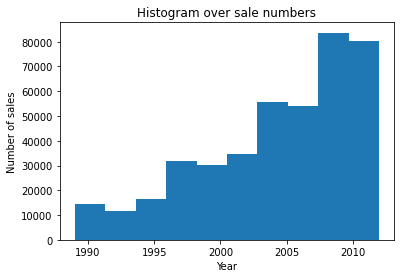

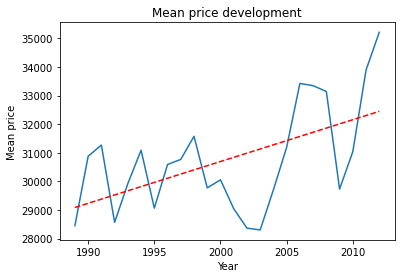

time: 1min 9s (started: 2021-02-11 08:28:36 +00:00)


In [ ]:
#DATA STATISTICS
data.describe()
#SalePrice:
max_price = data['SalePrice'].max()
min_price = data['SalePrice'].min()
mean_price = data['SalePrice'].mean()
print("SalePrice statistics:\nMaximum price: " + "%.1f" % max_price + "\nMinimum price: " + "%.1f" % min_price + "\nMean price: " + "%.1f" % mean_price)

#Sale period:
first_sale = data['saledate'].min()
last_sale = data['saledate'].max()
print("Construction machinery was sold from " + str(first_sale.date()) + " to " + str(last_sale.date()) + ".")

#Sale numbers in histogram:
plt.figure()
plt.hist(data['saledate'].apply(lambda x: x.year))
plt.xlabel('Year')
plt.ylabel('Number of sales')
plt.title('Histogram over sale numbers')
plt.show()

#Price development:
nr_sale_years = int(last_sale.year)-int(first_sale.year)+1
sale_years = np.linspace(int(first_sale.year),int(last_sale.year),nr_sale_years)
sale_numbers = np.zeros(len(sale_years))
sale_sum = np.zeros(len(sale_years))

for index,row in data.iterrows():
  for i in range(0,len(sale_years)):
    if sale_years[i] == row['saledate'].year:
      sale_numbers[i] += 1
      sale_sum[i] += row['SalePrice']
      break
mean_price = np.zeros(len(sale_years))
for i in range(0,len(sale_years)):
  mean_price[i] = sale_sum[i] / sale_numbers[i]
coef = np.polyfit(sale_years, mean_price,1)
poly1d_fn = np.poly1d(coef) 
plt.figure()
plt.plot(sale_years, mean_price, sale_years, poly1d_fn(sale_years), '--r')
plt.xlabel('Year')
plt.ylabel('Mean price')
plt.title('Mean price development')
plt.show()


In [ ]:
data.describe(include='all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_year,saledate_month,saledate_week,saledate_day,saledate_daysofweek
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05,73670,412698,412698,412698,271971,58667,74816,196093,412698,412698,412698,412698,107087,412364,197715,81096,152728,81096,188007,81096,25983,25983,25983,25983,330133,25983,106945,25994,25983,97638,220679,44974,44875,44875,102193,102916,102261,102332,102261,102193,80712,81875,81877,71564,71522,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4013,5059,1961,177,129,140,6,74,53,6,6,4,6,2,4,3,2,8,2,2,6,3,2,12,2,4,2,3,17,3,2,2,3,2,19,29,3,3,3,2,10,7,4,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Medium,2009-02-16 00:00:00,310G,580,C,II,L,Medium,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Florida,TEX,Track Excavators,Two Wheel Drive,OROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,None or Unspecified,14',None or Unspecified,No,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None or Unspecified,PAT,None or Unspecified,Standard,Conventional,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35832,1932,5348,20179,44431,13770,16464,64342,57542,67320,104230,104230,47546,177971,183061,72395,79389,49854,143915,77111,25406,9867,22469,24642,145317,20017,85405,13033,16832,47823,190449,41727,41820,44251,87463,82444,81539,85074,92924,86998,80692,39633,71447,70169,70774,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989-01-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-04-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004.317382,6.300268,25.721191,16.152894,2.594338
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.821090,3.437276,14.841265,8.429510,1.417971
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989.000000,1.000000,1.000000,1.000000,0.000000
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00,NaN,NaN,NaN,

time: 2.37 s (started: 2021-02-09 08:34:53 +00:00)


In [ ]:
#ROWS WITH MISSING VALUES
print("Original data shape:\n" + str(data.shape))
data[data==np.inf]=np.nan #replaces inf with nan
print("Rows with missing values:\n " + str(data.isnull().sum()))

Original data shape:
(412698, 58)
Rows with missing values:
 SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                2

Text(0, 0.5, '% nan values')

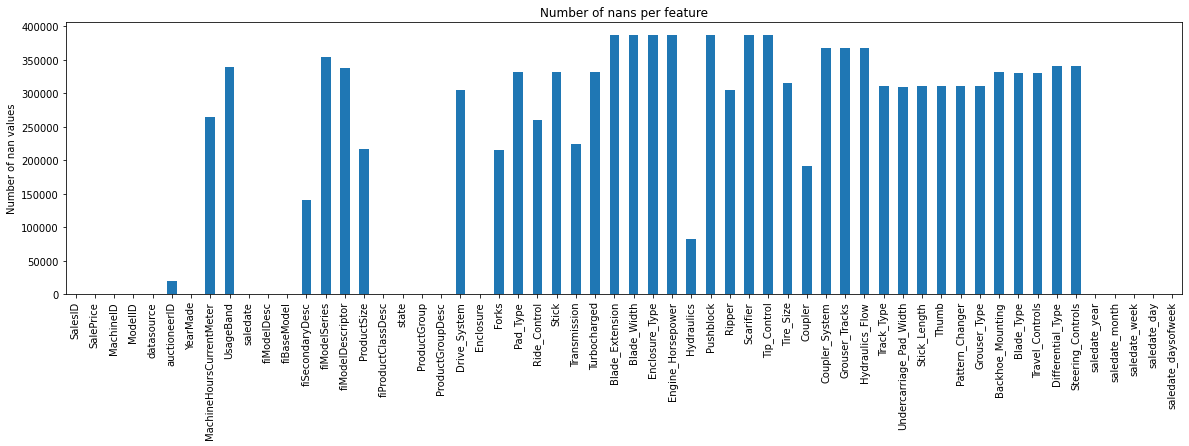

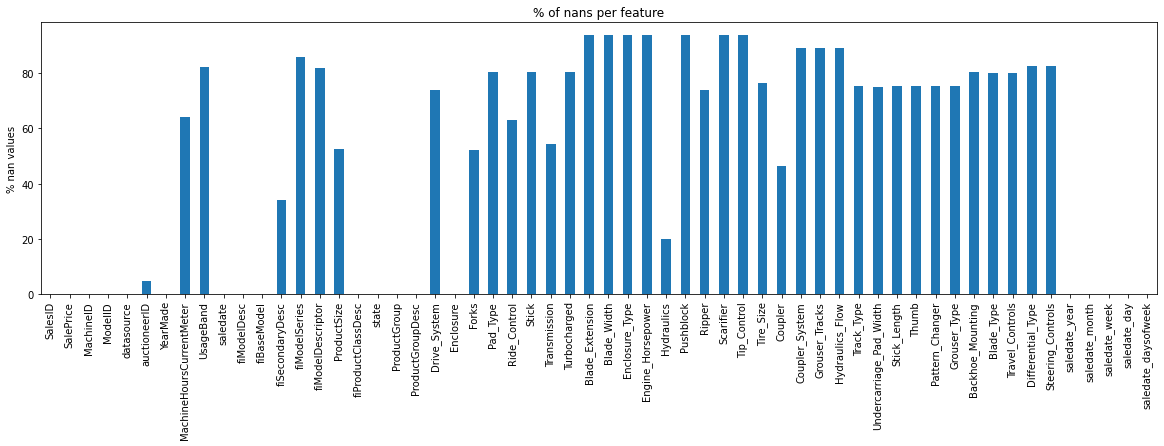

time: 3.33 s (started: 2021-02-11 08:55:57 +00:00)


In [ ]:
#VISUALIZING NUMBER OF MISSING VALUE PER FEATURE
fig, ax = plt.subplots(figsize=(20,5))
ax = (data.isnull().sum()).plot(kind='bar', title='Number of nans per feature')
ax.set_ylabel('Number of nan values')

fig2, ax2 = plt.subplots(figsize=(20,5))
ax2 = (data.isnull().sum()/data.shape[0]*100).plot(kind='bar', title='% of nans per feature')
ax2.set_ylabel('% nan values')


In [ ]:
#REMOVING DUPLICATES
data.drop_duplicates(keep="first",inplace=True)

In [ ]:
#REMOVAL OF ROWS WITH MISSING VALUES
data_1 = data.copy()
print(str(data_1.isnull().sum().max()) + " has been removed from the dataset.")
data_1.dropna(inplace=True) 
print("The new dataset size is :\n" + str(data_1.shape))
#No remaining rows; method not applicable

In [ ]:
#IMPUTATION OF MISSING VALUES - MOST COMMON CATEGORY
data['UsageBand']= data['UsageBand'].fillna(data['UsageBand'].value_counts().index[0])
data['ProductSize']=data['ProductSize'].fillna(data['ProductSize'].value_counts().index[0])
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_year,saledate_month,saledate_week,saledate_day,saledate_daysofweek
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,Medium,58,0,5,5,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,61,32,5,5,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,Medium,38,31,2,2,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,7,43,3,3,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,Medium,39,31,2,2,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3


time: 196 ms (started: 2021-02-11 10:20:53 +00:00)


In [ ]:
#IMPUTATION OF MISSING VALUES - MEAN VALUE
data['MachineHoursCurrentMeter']= data['MachineHoursCurrentMeter'].fillna(data['MachineHoursCurrentMeter'].mean())
data.head()
#consider performing grid search with median

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_year,saledate_month,saledate_week,saledate_day,saledate_daysofweek
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,Medium,58,0,5,5,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,61,32,5,5,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,Medium,38,31,2,2,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,7,43,3,3,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,Medium,39,31,2,2,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3


time: 89.3 ms (started: 2021-02-11 10:20:58 +00:00)


In [ ]:
#IMPUTATION OF MISSING VALUES - 0 
data['fiBaseModel']= data['fiBaseModel'].fillna(0)
data['fiSecondaryDesc']= data['fiSecondaryDesc'].fillna(str(0))
data['fiModelSeries']= data['fiModelSeries'].fillna(str(0))
data['fiModelDescriptor']= data['fiModelDescriptor'].fillna(str(0))
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_year,saledate_month,saledate_week,saledate_day,saledate_daysofweek
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,0,0,Medium,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,0,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,0,0,0,Medium,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,0,-6E,0,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,0,0,0,Medium,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3


time: 199 ms (started: 2021-02-10 09:52:25 +00:00)


In [ ]:
#LABELING OF CATEGORY
data['state'] = LabelEncoder().fit_transform(data['state'])
data['ProductGroup'] = LabelEncoder().fit_transform(data['ProductGroup'])
data['ProductGroupDesc'] = LabelEncoder().fit_transform(data['ProductGroupDesc'])
data['fiProductClassDesc'] = LabelEncoder().fit_transform(data['fiProductClassDesc'])
data['ProductSize'] = LabelEncoder().fit_transform(data['ProductSize'])
data['UsageBand'] = LabelEncoder().fit_transform(data['UsageBand'])
data.head()


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_year,saledate_month,saledate_week,saledate_day,saledate_daysofweek
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,1,2006-11-16,521D,521,D,NaN,NaN,3,58,0,5,5,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,1,2004-03-26,950FII,950,F,II,NaN,3,61,32,5,5,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,0,2004-02-26,226,226,NaN,NaN,NaN,3,38,31,2,2,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,0,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,5,7,43,3,3,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,2,2009-07-23,S175,S175,NaN,NaN,NaN,3,39,31,2,2,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3


time: 849 ms (started: 2021-02-11 10:21:07 +00:00)


In [ ]:
def correlation_heatmap(train):
    correlations = train_X.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    

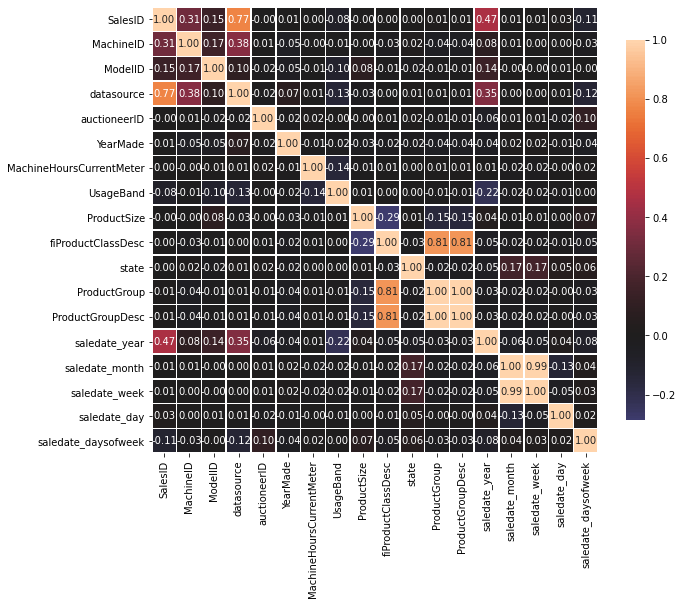

time: 2.38 s (started: 2021-02-11 10:21:48 +00:00)


In [ ]:
#FEATURE CORRELATION
Y_col = ['SalePrice']
X = data.drop(Y_col, axis=1) #Input dataframe, X
Y = pd.DataFrame(data, columns=Y_col) #Output dataframe, Y

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)
correlation_heatmap(train_X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


Text(0, 0.5, '% change')

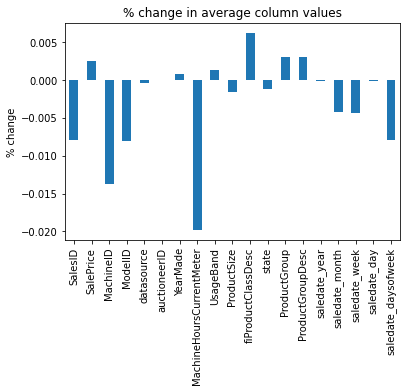

time: 5min 58s (started: 2021-02-11 10:22:27 +00:00)


In [ ]:
#CHECKING HOW THE MEAN IS AFFECTED BY DROPPING NAN IN 'AUCTIONID'
data_dropped = data.dropna(subset=['auctioneerID']) 
# change in means as a bar chart
ax = ((data_dropped.mean() - data.mean()) / data.mean()).plot(kind='bar', title='% change in average column values')
ax.set_ylabel('% change')


In [51]:
#REMOVING CONFIGURATION COLUMNS
configuration_columns = ["Drive_System","Enclosure","Forks","Pad_Type","Ride_Control","Stick","Transmission","Turbocharged","Blade_Extension","Blade_Width","Enclosure_Type","Engine_Horsepower","Hydraulics","Pushblock","Ripper","Scarifier","Tip_Control","Tire_Size","Coupler","Coupler_System","Grouser_Tracks","Hydraulics_Flow","Track_Type","Undercarriage_Pad_Width","Stick_Length","Thumb","Pattern_Changer","Grouser_Type","Backhoe_Mounting","Blade_Type","Travel_Controls","Differential_Type","Steering_Controls"]
model_desc_columns = ["fiModelDesc","fiBaseModel","fiSecondaryDesc","fiModelSeries","fiModelDescriptor"]
sale_date_column = ["saledate"]
data_2 = data.copy()
data_2 = data_2.drop(configuration_columns, axis=1) 
data_2 = data_2.drop(model_desc_columns, axis=1) 
data_2 = data_2.drop(sale_date_column, axis=1) 
data_2.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,saledate_year,saledate_month,saledate_week,saledate_day,saledate_daysofweek
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,1,3,58,0,5,5,2006,11,46,16,3
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,1,3,61,32,5,5,2004,3,13,26,4
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,0,3,38,31,2,2,2004,2,9,26,3
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,0,5,7,43,3,3,2011,5,20,19,3
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,2,3,39,31,2,2,2009,7,30,23,3


time: 686 ms (started: 2021-02-11 12:14:19 +00:00)


In [ ]:
print("Rows with missing values:\n " + str(data_2.isnull().sum()))

Rows with missing values:
 SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                20136
YearMade                        0
MachineHoursCurrentMeter        0
UsageBand                       0
ProductSize                     0
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
saledate_year                   0
saledate_month                  0
saledate_week                   0
saledate_day                    0
saledate_daysofweek             0
dtype: int64
time: 24.7 ms (started: 2021-02-10 09:59:43 +00:00)


In [ ]:
data_2.dropna(inplace=True) #remove rows with nan

In [ ]:
#FEATURE CORRELATION
Y_col = ['SalePrice']
X = data_2.drop(Y_col, axis=1) #Input dataframe, X
Y = pd.DataFrame(data_2, columns=Y_col) #Output dataframe, Y

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)
    

In [ ]:
#EXTRA TREES
et_500 = ExtraTreesRegressor(n_estimators=20, n_jobs=-1, random_state=300)
et_500.fit(train_X,train_Y)
predicted = et_500.predict(test_X)
scores = cross_val_score(et_500, X, Y, cv=5, scoring='r2')

In [ ]:
def r2(y_true,y_pred):
    return roundup(r2_score(y_true,y_pred))

def roundup(a, digits=4):
    n = 10**-digits
    return round(math.ceil(a / n) * n, digits)

In [60]:
print(scores)

[0.83255217 0.74353115 0.74826195 0.81384428 0.74239714]
time: 5.29 ms (started: 2021-02-11 12:19:09 +00:00)


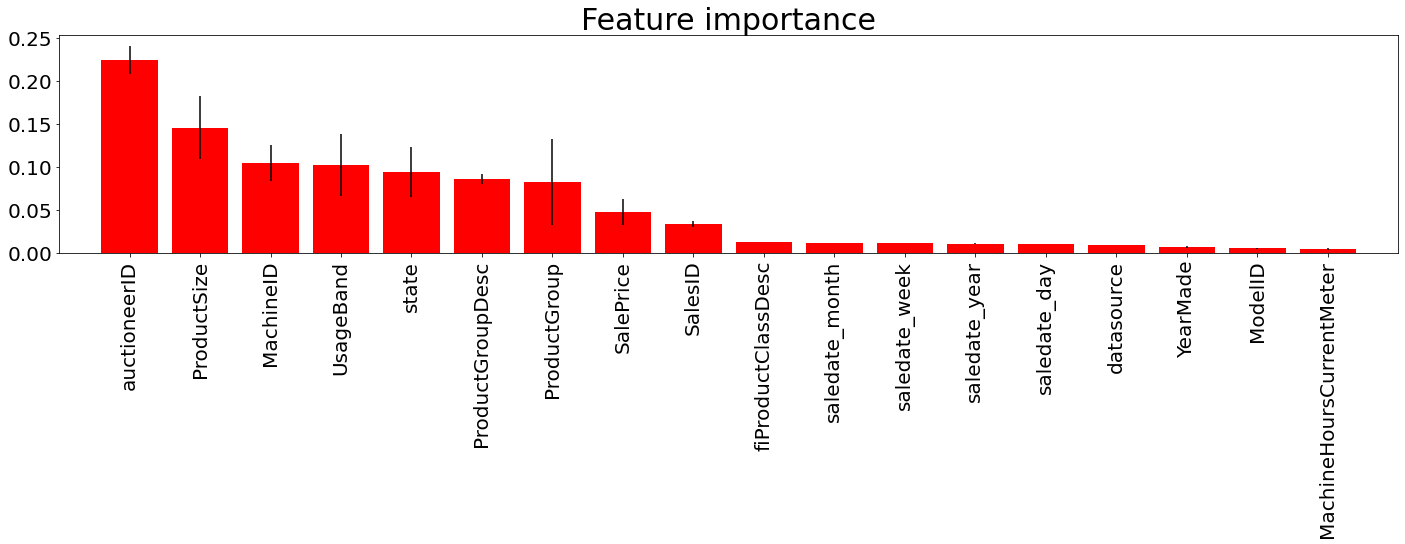

time: 905 ms (started: 2021-02-11 10:34:44 +00:00)


In [ ]:
featureDisplay = data_2.columns
nr_features = data_2.shape[1]
def plot_feature_importances(et):
    skplt.estimators.plot_feature_importances(et,text_fontsize=16,max_num_features=nr_features,figsize=(24,4),feature_names=featureDisplay)
plot_feature_importances(et_500)
plt.xticks(rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Feature importance', fontsize = 30)
plt.show()

In [61]:
#REMOVING CORRELATING COLUMNS
correlating_columns = ["SalesID","ProductGroupDesc","saledate_week","fiProductClassDesc"]
data_3 = data_2.copy()
data_3 = data_3.drop(correlating_columns, axis=1) 
data_3.head()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,ProductSize,state,ProductGroup,saledate_year,saledate_month,saledate_day,saledate_daysofweek
0,66000.0,999089,3157,121,3.0,2004,68.0,1,3,0,5,2006,11,16,3
1,57000.0,117657,77,121,3.0,1996,4640.0,1,3,32,5,2004,3,26,4
2,10000.0,434808,7009,121,3.0,2001,2838.0,0,3,31,2,2004,2,26,3
3,38500.0,1026470,332,121,3.0,2001,3486.0,0,5,43,3,2011,5,19,3
4,11000.0,1057373,17311,121,3.0,2007,722.0,2,3,31,2,2009,7,23,3


time: 64.8 ms (started: 2021-02-11 12:19:10 +00:00)


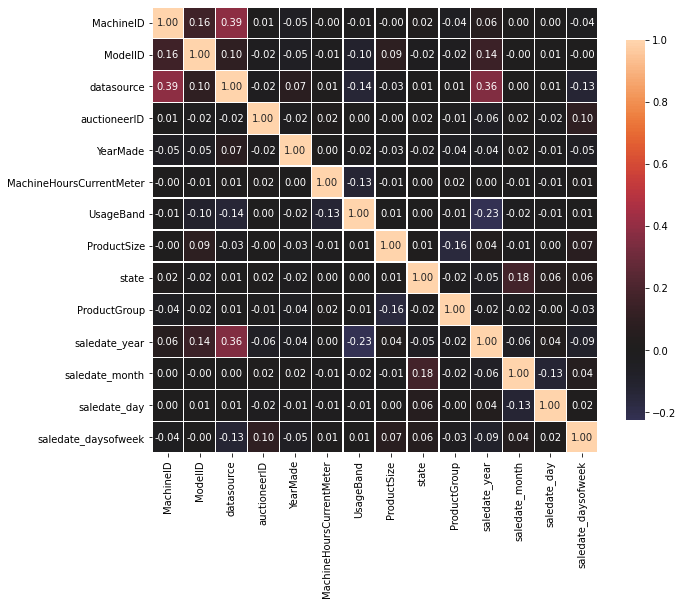

time: 1.29 s (started: 2021-02-11 10:56:26 +00:00)


In [ ]:
#FEATURE CORRELATION
Y_col = ['SalePrice']
X = data_3.drop(Y_col, axis=1) #Input dataframe, X
Y = pd.DataFrame(data_3, columns=Y_col) #Output dataframe, Y

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
#EXTRA TREES
from sklearn.ensemble import ExtraTreesRegressor
et_500 = ExtraTreesRegressor(n_estimators=20, n_jobs=-1, random_state=300)
et_500.fit(train_X,train_Y)
predicted = et_500.predict(test_X)
scores = cross_val_score(et_500, X, Y, cv=5, scoring='r2')

In [ ]:
print(scores)

[0.80487367 0.68861575 0.69073371 0.76852319 0.71035338]
time: 5.13 ms (started: 2021-02-11 10:58:49 +00:00)


In [62]:
#REMOVING CONFIGURATION COLUMNS
correlating_columns = ["SalesID","ProductGroupDesc","saledate_week"]
data_4 = data_2.copy()
data_4 = data_4.drop(correlating_columns, axis=1) 
data_4.head()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,ProductSize,fiProductClassDesc,state,ProductGroup,saledate_year,saledate_month,saledate_day,saledate_daysofweek
0,66000.0,999089,3157,121,3.0,2004,68.0,1,3,58,0,5,2006,11,16,3
1,57000.0,117657,77,121,3.0,1996,4640.0,1,3,61,32,5,2004,3,26,4
2,10000.0,434808,7009,121,3.0,2001,2838.0,0,3,38,31,2,2004,2,26,3
3,38500.0,1026470,332,121,3.0,2001,3486.0,0,5,7,43,3,2011,5,19,3
4,11000.0,1057373,17311,121,3.0,2007,722.0,2,3,39,31,2,2009,7,23,3


time: 77.7 ms (started: 2021-02-11 12:20:55 +00:00)


In [ ]:
#FEATURE CORRELATION
Y_col = ['SalePrice']
X = data_4.drop(Y_col, axis=1) #Input dataframe, X
Y = pd.DataFrame(data_4, columns=Y_col) #Output dataframe, Y

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
#EXTRA TREES
et_500 = ExtraTreesRegressor(n_estimators=20, n_jobs=-1, random_state=300)
et_500.fit(train_X,train_Y)
predicted = et_500.predict(test_X)
scores = cross_val_score(et_500, X, Y, cv=5, scoring='r2')

In [66]:
print(scores)

[0.85396176 0.74784056 0.7644777  0.8179884  0.80390457]
time: 1.55 ms (started: 2021-02-11 12:23:39 +00:00)


In [67]:
#REMOVING CONFIGURATION COLUMNS
correlating_columns = ["SalesID","ProductGroupDesc","saledate_week", "datasource", "ProductGroup"]
data_5 = data_2.copy()
data_5 = data_5.drop(correlating_columns, axis=1) 
data_5.head()

,SalePrice,MachineID,ModelID,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,ProductSize,fiProductClassDesc,state,saledate_year,saledate_month,saledate_day,saledate_daysofweek
0,66000.0,999089,3157,3.0,2004,68.0,1,3,58,0,2006,11,16,3
1,57000.0,117657,77,3.0,1996,4640.0,1,3,61,32,2004,3,26,4
2,10000.0,434808,7009,3.0,2001,2838.0,0,3,38,31,2004,2,26,3
3,38500.0,1026470,332,3.0,2001,3486.0,0,5,7,43,2011,5,19,3
4,11000.0,1057373,17311,3.0,2007,722.0,2,3,39,31,2009,7,23,3


time: 64.4 ms (started: 2021-02-11 12:23:39 +00:00)


In [ ]:
#FEATURE CORRELATION
Y_col = ['SalePrice']
X = data_5.drop(Y_col, axis=1) #Input dataframe, X
Y = pd.DataFrame(data_5, columns=Y_col) #Output dataframe, Y

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
#EXTRA TREES
et_500 = ExtraTreesRegressor(n_estimators=20, n_jobs=-1, random_state=300)
et_500.fit(train_X,train_Y)
predicted = et_500.predict(test_X)

In [ ]:
scores = cross_val_score(et_500, X, Y, cv=5, scoring='r2')

In [76]:
print(scores)

[0.84477867 0.75995921 0.77168187 0.83521472 0.83196574]
time: 4.54 ms (started: 2021-02-11 13:33:25 +00:00)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best: 0.890595 using {'n_estimators': 85}
0.866664 (0.003073) with: {'n_estimators': 5}, fit time: 10.330402, score time: 0.315990
0.883097 (0.001281) with: {'n_estimators': 15}, fit time: 34.587850, score time: 1.122921
0.886666 (0.001032) with: {'n_estimators': 25}, fit time: 50.003767, score time: 1.546626
0.887827 (0.000853) with: {'n_estimators': 35}, fit time: 70.546381, score time: 2.137750
0.888383 (0.001056) with: {'n_estimators': 45}, fit time: 93.621924, score time: 2.800395
0.889549 (0.000639) with: {'n_estimators': 55}, fit time: 114.574925, score time: 3.402915
0.889816 (0.001360) with: {'n_estimators': 65}, fit time: 133.471437, score time: 3.978394
0.889930 (0.001161) with: {'n_estimators': 75}, fit time: 154.635405, score time: 4.586977
0.890595 (0.000831) with: {'n_estimators': 85}, fit time: 174.021974, score time: 5.226655
0.890317 (0.000776) with: {'n_estimators': 95}, fit time: 182.618446, score time: 5.738038


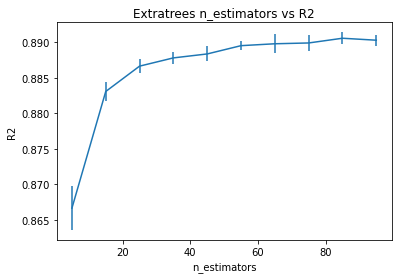

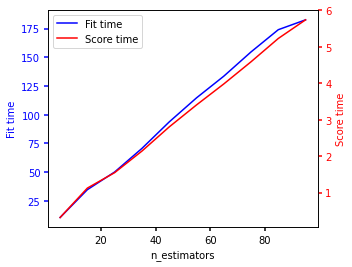

time: 47min 24s (started: 2021-02-11 12:24:06 +00:00)


In [71]:
#GRID SEARCH OF EXTRATREE SIZE
Y_col = ['SalePrice']
X = data_4.drop(Y_col, axis=1) #Input dataframe, X
Y = pd.DataFrame(data_4, columns=Y_col) #Output dataframe, Y

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)
# grid search
et_500 = ExtraTreesRegressor()
n_estimators = range(5,100,10)
param_grid = dict(n_estimators=n_estimators)
grid_search = GridSearchCV(et_500, param_grid, scoring="r2", n_jobs=-1, cv=5)
grid_result = grid_search.fit(train_X, train_Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
fit_time = grid_result.cv_results_['mean_fit_time']
score_time = grid_result.cv_results_['mean_score_time']
for mean, stdev, param, f_t,s_t in zip(means, stds, params, fit_time,score_time):
	print("%f (%f) with: %r, fit time: %f, score time: %f" % (mean, stdev, param,f_t,s_t))
# plot accuracy
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("Extratrees n_estimators vs R2")
plt.xlabel('n_estimators')
plt.ylabel('R2')
plt.savefig('n_estimators.png')

# plot time
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()

p1, = host.plot(n_estimators, fit_time, "b-", label="Fit time")
p2, = par1.plot(n_estimators, score_time, "r-", label="Score time")

host.set_xlabel('n_estimators')
host.set_ylabel("Fit time")
par1.set_ylabel("Score time")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)


lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

In [ ]:
 # PERFORMANCE:
 print("Best Accuracy: {}".format(grid_result.best_score_))
 # the best parameters that caused the best accuracy
 print("Best Parameters: {}".format(grid_result.best_params_))
 # the average time it took a model to fit to the data (in seconds)
 print("Average Time to Fit (s):{}".format(round(grid_result.cv_results_['mean_fit_time'].mean(), 3)))
 # the average time it took a model to predict out of sample data (in seconds)
 print("Average Time to Score (s):{}".format(round(grid_result.cv_results_['mean_score_time'].mean(), 3)))

Best Accuracy: 0.8902115734601045
Best Parameters: {'n_estimators': 95}
Average Time to Fit (s):82.752
Average Time to Score (s):2.422
time: 6.38 ms (started: 2021-02-10 10:43:06 +00:00)
